<a href="https://colab.research.google.com/github/attackgnome/TensorFlowCourses/blob/master/C4/W4/assignment/C4_W4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2022-01-01 22:14:02--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2022-01-01 22:14:03 (4.31 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



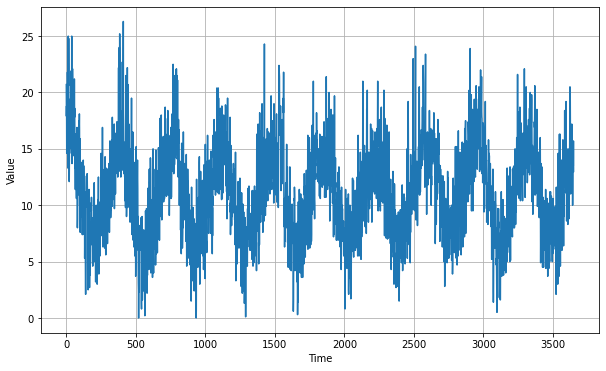

In [4]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

      ### END CODE HERE
      
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  ### START CODE HERE  
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
  ### END CODE HERE
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 15s 771ms/step - loss: 13.8545 - mae: 14.3520 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 8s 736ms/step - loss: 13.1439 - mae: 13.6404 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 8s 728ms/step - loss: 12.5546 - mae: 13.0506 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 8s 730ms/step - loss: 11.5081 - mae: 12.0032 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 9s 801ms/step - loss: 10.7362 - mae: 11.2303 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 8s 734ms/step - loss: 9.6820 - mae: 10.1737 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 8s 730ms/step - loss: 8.9937 - mae: 9.4846 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 8s 741ms/step - loss: 8.2041 - mae: 8.6932

(1e-08, 0.0001, 0.0, 20.0)

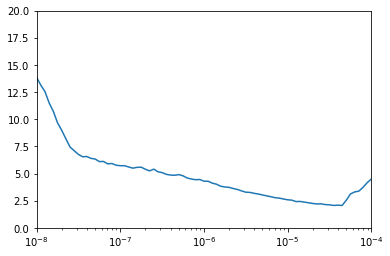

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 20])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  ### START CODE HERE  
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
  ### END CODE HERE
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=4e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, callbacks = [earlystop])
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/500
25/25 [==============================] - 14s 303ms/step - loss: 7.0227 - mae: 7.5064
Epoch 2/500
25/25 [==============================] - 8s 303ms/step - loss: 3.4668 - mae: 3.9401
Epoch 3/500
25/25 [==============================] - 8s 300ms/step - loss: 2.3785 - mae: 2.8406
Epoch 4/500
25/25 [==============================] - 8s 300ms/step - loss: 2.3800 - mae: 2.8429
Epoch 5/500
25/25 [==============================] - 8s 301ms/step - loss: 2.1175 - mae: 2.5756
Epoch 6/500
25/25 [==============================] - 9s 366ms/step - loss: 2.0544 - mae: 2.5117
Epoch 7/500
25/25 [==============================] - 8s 302ms/step - loss: 2.0908 - mae: 2.5489
Epoch 8/500
25/25 [==============================] - 8s 298ms/step - loss: 1.9733 - mae: 2.4288
Epoch 9/500
25/25 [==============================] - 8s 307ms/step - loss: 1.9387 - mae: 2.3937
Epoch 10/500
25/25 [==============================] - 8s 302ms/step - loss: 1.9194 - mae: 2.3741
Epoch 11/500
25/25 [==================

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[(split_time - window_size):-1, -1]

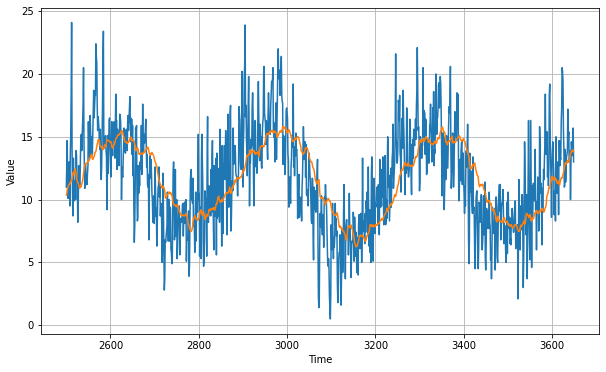

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

2.3580432

In [17]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[10.370062 10.436867 10.726933 ... 13.945411 13.942678 13.820299]
